In [3]:
import yaml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import pandas as pd
import json
from scipy.stats import spearmanr
import rasterio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.spatial import distance
from matplotlib.ticker import ScalarFormatter
import math
from scipy.optimize import curve_fit
import cv2
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import ttest_rel
import pickle
import h5py
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [4]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

# 會用到的函數

In [5]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', linewidth=2, **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param linewidth: 椭圆的线条粗细。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状，使用 linewidth 来调整线条粗细
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, 
                      linewidth=linewidth, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png
# 顯著性標示函式
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'n.s.'
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [6]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
create_folder(plot_path_df)
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
create_folder(plot_path_nichespace)

In [7]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)

In [8]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [9]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

## 計算niche相似度與共域次數的關聯

In [10]:
coocc_counts = pd.read_csv('./workspace/species_data/cooccurrence_data/cooccurrence.csv', sep = '\t')
coocc_counts = coocc_counts[(coocc_counts.sp1.isin(species_list_predict)) & 
                            (coocc_counts.sp2.isin(species_list_predict)) & 
                            (coocc_counts.sp1 != coocc_counts.sp2) & 
                            (coocc_counts.counts != 0)].reset_index(drop = True)

### euclidean 距離

In [11]:
# 定義路徑生成與條件檢查
def generate_path(base_path, species, model, suffix):
    return base_path.replace('[SPECIES]', species).replace('[MODEL]', model).replace('[SUFFIX]', suffix)

def all_files_exist(*paths):
    return all(os.path.exists(path) for path in paths)

# 预加载文件到内存
def preload_nichespace_files(coocc_counts, plot_path_nichespace, suffix = 'max'):
    nichespace_cache = {}
    unique_species = set(coocc_counts['sp1']).union(set(coocc_counts['sp2']))
    
    for sp in unique_species:
        for model, suf in [('deepsdm', suffix), ('maxent', suffix)]:
            path = generate_path(os.path.join(plot_path_nichespace, '[SPECIES]_[MODEL]_all_season_nichespace_[SUFFIX].tif'), sp, model, suf)
            if os.path.exists(path):
                with rasterio.open(path, 'r') as f:
                    img = f.read(1)
                    nichespace_cache[(sp, model)] = img.flatten()[img.flatten() > 0]  # 过滤非正值
    return nichespace_cache

def process_row(data, nichespace_cache):
    
    if all([(sp, 'deepsdm') in nichespace_cache for sp in [data.sp1, data.sp2]]):
        niche_space_deepsdm = [nichespace_cache[(sp, 'deepsdm')] for sp in [data.sp1, data.sp2]]
    else:
        niche_space_deepsdm = None
        
    if all([(sp, 'maxent') in nichespace_cache for sp in [data.sp1, data.sp2]]):
        niche_space_maxent = [nichespace_cache[(sp, 'maxent')] for sp in [data.sp1, data.sp2]]
    else:
        niche_space_maxent = None

    # 计算 Cosine Similarity
    try:
        euclidean_deepsdm = euclidean_distances(niche_space_deepsdm[0].reshape(1, -1), niche_space_deepsdm[1].reshape(1, -1)).reshape(-1)
    except:
        euclidean_deepsdm = None
    try:
        euclidean_maxent = euclidean_distances(niche_space_maxent[0].reshape(1, -1), niche_space_maxent[1].reshape(1, -1)).reshape(-1)
    except:
        euclidean_maxent =None
    
    return data.counts, euclidean_deepsdm, euclidean_maxent

In [12]:
# 预加载栖息空间文件
print("Preloading nichespace files...")
nichespace_cache = preload_nichespace_files(coocc_counts, plot_path_nichespace, 'max')

print("Processing co-occurrence data...")
results =[]
for i, data in coocc_counts.iterrows():
    print(f'\r{i+1}', end = '')
    results.append(process_row(data, nichespace_cache))
    
# 收集结果
valid_results = [r for r in results if all(r)]

# 解包结果
counts, deepsdm_euclidean, maxent_euclidean = zip(*valid_results)

# 计算 Spearman 相关系数
rho_euclidean_deepsdm, p_euclidean_deepsdm = spearmanr(np.array(deepsdm_euclidean), np.array(counts))
rho_euclidean_maxent, p_euclidean_maxent = spearmanr(np.array(maxent_euclidean), np.array(counts))

# 输出结果
print(f'\rrho of deepsdm: {rho_euclidean_deepsdm}, p-value: {p_euclidean_deepsdm}')
print(f'\rrho of maxent: {rho_euclidean_maxent}, p-value: {p_euclidean_maxent}')

Preloading nichespace files...
Processing co-occurrence data...
7127

ValueError: not enough values to unpack (expected 3, got 0)

NameError: name 'counts' is not defined

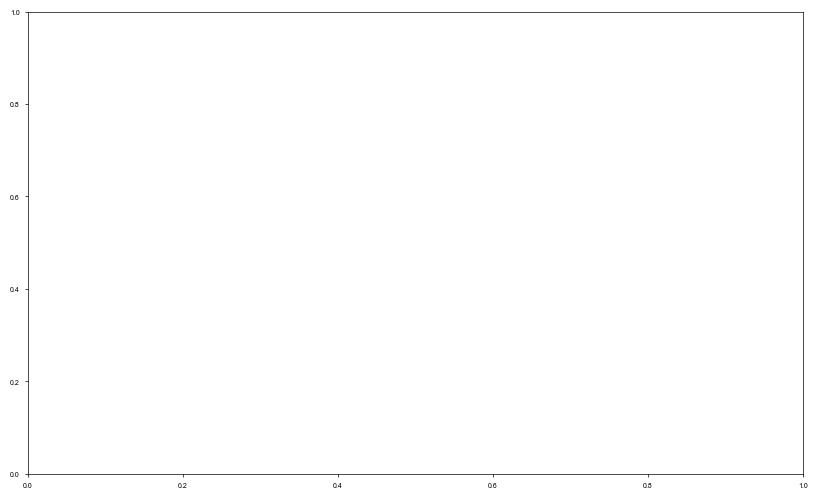

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(counts)+1), deepsdm_euclidean)
ax.set_title('DeepSDM (Euclidean distance)')

Text(0.5, 1.0, 'MaxEnt (Euclidean distance)')

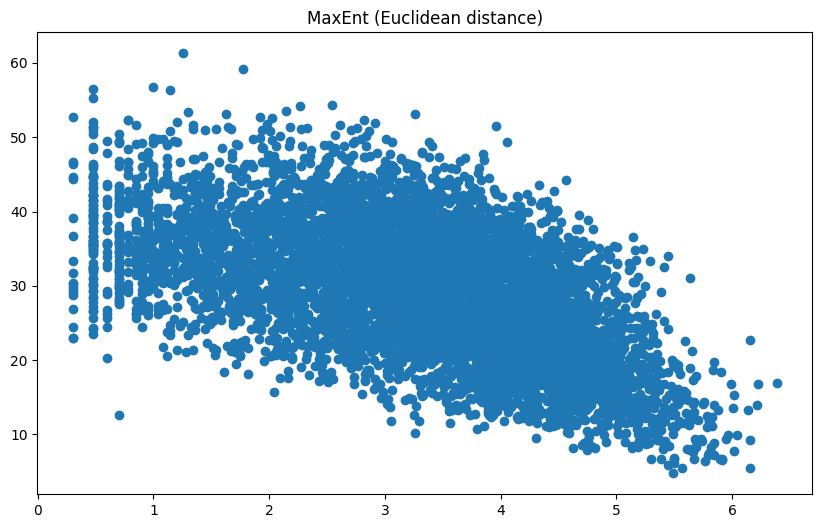

In [142]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(np.array(counts)+1), maxent_euclidean)
ax.set_title('MaxEnt (Euclidean distance)')

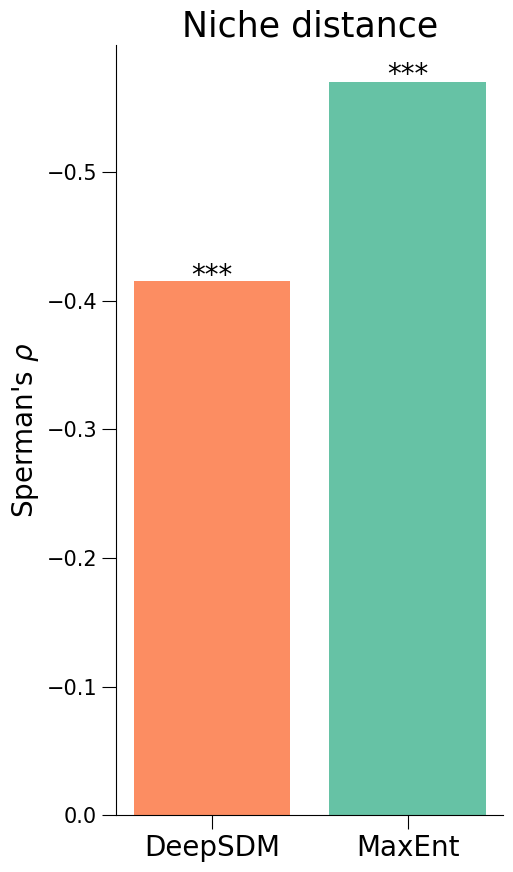

In [135]:
fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(['DeepSDM', 'MaxEnt'], [rho_deepsdm, rho_maxent], color = ['#fc8d62', '#66c2a5'])
ax.set_ylabel(rf"Sperman's $\rho$", size = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', which='both', labelsize=20, length = 10)
ax.tick_params(axis='y', which='both', labelsize=15, length = 10)
ax.set_title('Niche distance', size = 25)
ax.invert_yaxis()
ax.text(0, rho_deepsdm*1.01, get_significance_stars(p_deepsdm), ha = 'center', va = 'center', size = 20)
ax.text(1, rho_maxent*1.01, get_significance_stars(p_maxent), ha = 'center', va = 'center', size = 20)

path_out = os.path.join(plot_path_nichespace, 'rho_bar_euclidean_distance.pdf')
# plt.savefig(path_out, dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()

### cosine similarity

In [123]:
# 路径生成函数
def generate_path(base_path, species, model, suffix):
    return base_path.replace('[SPECIES]', species).replace('[MODEL]', model).replace('[SUFFIX]', suffix)

# 手动计算 Cosine Similarity
def cosine_similarity_manual(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return dot_product / norm_product if norm_product != 0 else 0

# 处理单行数据
def process_row(data, nichespace_cache):
    if all([(sp, 'deepsdm') in nichespace_cache for sp in [data.sp1, data.sp2]]):
        niche_space_deepsdm = [nichespace_cache[(sp, 'deepsdm')] for sp in [data.sp1, data.sp2]]
    else:
        niche_space_deepsdm = None
        
    if all([(sp, 'maxent') in nichespace_cache for sp in [data.sp1, data.sp2]]):
        niche_space_maxent = [nichespace_cache[(sp, 'maxent')] for sp in [data.sp1, data.sp2]]
    else:
        niche_space_maxent = None
    # 计算 Cosine Similarity
    try:
        cosine_deepsdm = cosine_similarity(niche_space_deepsdm[0].reshape(1, -1), niche_space_deepsdm[1].reshape(1, -1)).reshape(-1)
    except:
        cosine_deepsdm = None
    try:
        cosine_maxent = cosine_similarity(niche_space_maxent[0].reshape(1, -1), niche_space_maxent[1].reshape(1, -1)).reshape(-1)
    except:
        cosine_maxent =None
    
    return data.counts, cosine_deepsdm, cosine_maxent

In [126]:
# 预加载栖息空间文件
print("Preloading nichespace files...")
nichespace_cache = preload_nichespace_files(coocc_counts, plot_path_nichespace, 'max')

print("Processing co-occurrence data...")
results =[]
for i, data in coocc_counts.iterrows():
    print(f'\r{i+1}', end = '')
    results.append(process_row(data, nichespace_cache))
    
# 收集结果
valid_results = [r for r in results if all(r)]

# 解包结果
counts, deepsdm_cosine, maxent_cosine = zip(*valid_results)

# 计算 Spearman 相关系数
rho_cosine_deepsdm, p_cosine_deepsdm = spearmanr(np.array(deepsdm_cosine), np.array(counts))
rho_cosine_maxent, p_cosine_maxent = spearmanr(np.array(maxent_cosine), np.array(counts))

# 输出结果
print(f'\rrho of deepsdm: {rho_cosine_deepsdm}, p-value: {p_cosine_deepsdm}')
print(f'\rrho of maxent: {rho_cosine_maxent}, p-value: {p_cosine_maxent}')

Preloading nichespace files...


/home/klok0126/.local/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing co-occurrence data...
rho of deepsdm: 0.7086958880952432, p-value: 0.0
rho of maxent: 0.5629931983817054, p-value: 0.0


Text(0.5, 1.0, 'DeepSDM (Cosine similarity)')

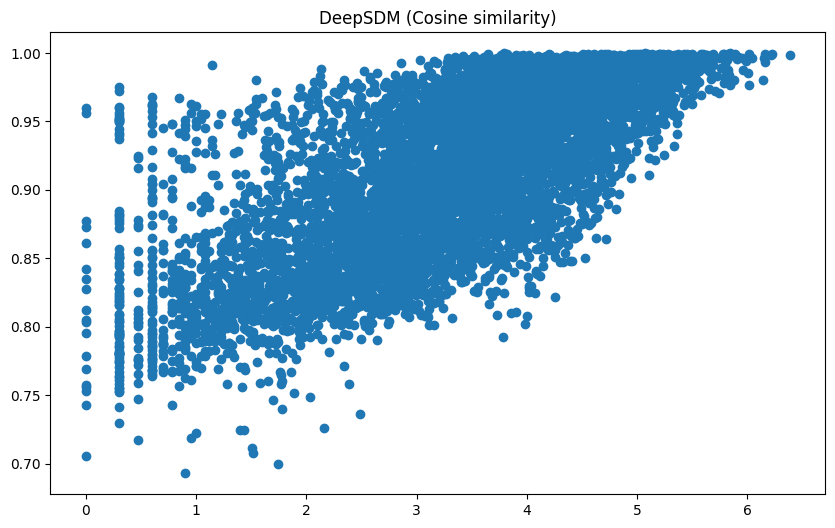

In [98]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(counts), deepsdm_cosine)
ax.set_title('DeepSDM (Cosine similarity)')

Text(0.5, 1.0, 'MaxEnt (Cosine similarity)')

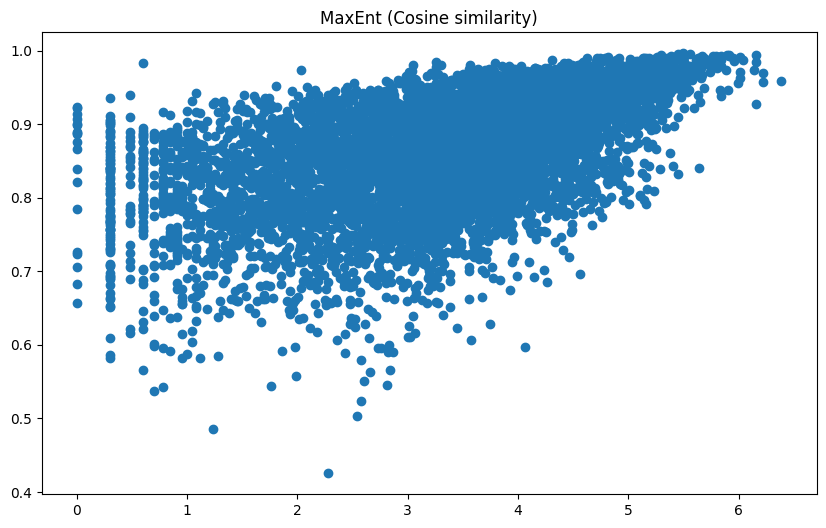

In [99]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(np.log10(counts), maxent_cosine)
ax.set_title('MaxEnt (Cosine similarity)')

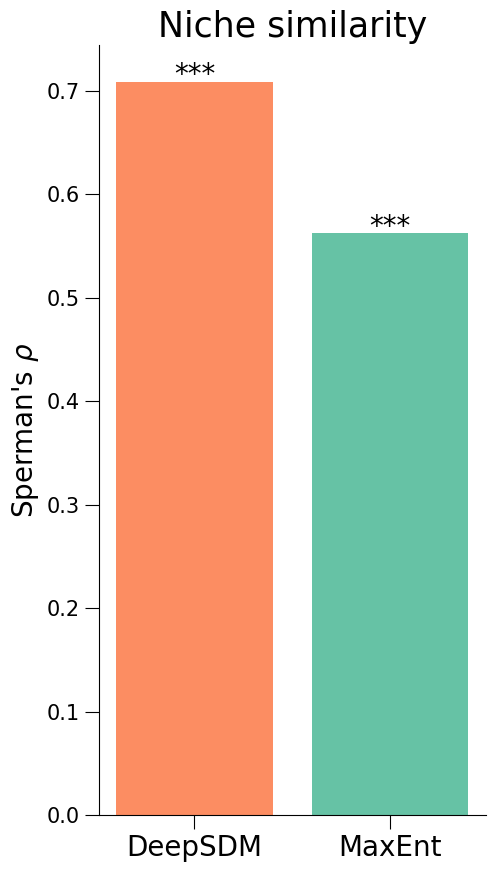

In [109]:
fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(['DeepSDM', 'MaxEnt'], [rho_cosine_deepsdm, rho_cosine_maxent], color = ['#fc8d62', '#66c2a5'], width = 0.8)
ax.set_ylabel(rf"Sperman's $\rho$", size = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', which='both', labelsize=20, length = 10)
ax.tick_params(axis='y', which='both', labelsize=15, length = 10)
ax.set_title('Niche similarity', size = 25)
ax.text(0, rho_cosine_deepsdm*1.01, get_significance_stars(p_cosine_deepsdm), ha = 'center', va = 'center', size = 20)
ax.text(1, rho_cosine_maxent*1.01, get_significance_stars(p_cosine_maxent), ha = 'center', va = 'center', size = 20)

path_out = os.path.join(plot_path_nichespace, 'rho_bar_cosine_similarity.pdf')
# plt.savefig(path_out, dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()